<a href="https://colab.research.google.com/github/trinade96/Fortiate_Project/blob/master/Gradient_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### In this notebook we will be looking at Gradient Bossting which are closely related with AdaBoost (Ensemble method) and Random Forest, Decision Trees. So while going through this it would be good to keep these topics in mind.
For understanding look at the following link: <br>
https://www.displayr.com/gradient-boosting-the-coolest-kid-on-the-machine-learning-block/ <br>
https://towardsdatascience.com/machine-learning-part-18-boosting-algorithms-gradient-boosting-in-python-ef5ae6965be4

In [72]:
!pip install imblearn

##### **Packages Used**

In [73]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, mean_absolute_error
from sklearn.datasets import load_boston
from pandas.api.types import is_float_dtype
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
import imblearn
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

##### **Reading the Data**

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
data = pd.read_excel('/gdrive/My Drive/Random-Forest-Rules-Final-Rearranged-mindmap.xlsx')
data.head()

,TRANSACTION_CURRENCY,PD4,PD11,PROC_CODE_12,PD8,MCC,POS_ENTRY_MODE,SERVICE_CODE,BILLING_AMOUNT,TRANSACTION_LOCAL_DATE,TRANSMISSION_DATE_TIME,RESPONSE_DATE_TIME,PAN,VALID_FROM,EXPIRY_DATE,PROC_CODE_34,PROC_CODE_56,PD1,PD2,PD3,PD5,PD6,PD7,PD9,PD10,PD12,TRANSACTION_AMOUNT,BILLING_CURRENCY,CONVERSION_RATE_DATE,SETTLEMENT_AMOUNT,SETTLEMENT_CURRENCY,SETTLEMENT_DATE,ACQUIRING_COUNTRY_CODE,CARD_ACCEPTOR_TERM_ID,CARD_ACCEPTOR_ID,CARD_ACC_NAME_ADDRESS,AUTHORIZATION_CODE,DECISION,TARGET,C_100,C_40,C_20,ECOM_INFO,E_COM_INDICATOR
0,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,147.84,21-MAR-18 11.33.24,21-MAR-18 11.33.24,21-MAR-18 11.33.24,A1586941252148110,21-AUG-17 17.10.11,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,147.84,CURR356,000,145.22,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,800204,RESULT000,0,AMI,ACS,T0784,AXASK05AEVV,ECI05
1,CURR356,ATC9,TOC1,TC00,TVI0,MCC4814,NNN,UNK,399.00,21-MAR-18 11.34.15,21-MAR-18 11.34.15,21-MAR-18 11.34.15,A1586941241334010,06-APR-16 20.19.15,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,399.00,CURR356,000,391.94,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9822047692,PAYTM RETAIL -PG-ONLINE \\NOIDA\201301\,300255,RESULT000,0,AMI,ACS,T0797,AXASK05AEVV,ECI05
2,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,247.20,21-MAR-18 11.36.47,21-MAR-18 11.36.47,21-MAR-18 11.36.48,A1586941049519010,03-APR-18 14.19.03,01-APR-23 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,247.20,CURR356,000,242.82,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,700408,RESULT000,0,AMI,ACS,T0537,AXASK05AEVV,ECI05
3,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,359.00,21-MAR-18 11.39.44,21-MAR-18 11.39.44,21-MAR-18 11.39.44,A1586941050671000,20-APR-18 19.43.48,01-APR-23 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,359.00,CURR356,000,352.65,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,700585,RESULT000,0,AMI,ACS,T0796,AXASK05AEVV,ECI05
4,CURR356,ATC9,TOC1,TC00,TVI0,MCC5999,NNN,UNK,188.00,21-MAR-18 11.43.08,21-MAR-18 11.43.08,21-MAR-18 11.43.08,A1586941257961010,30-APR-16 20.49.02,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,188.00,CURR356,000,183.81,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9820524155,PAYTM.COM WALLET PG \\NOIDA\201310\\,400788,RESULT000,0,AMI,ACS,T0784,AXASK05AEVV,ECI05


In [4]:
data.shape

(105271, 44)

##### **Encoding the data**

##### We will be treating the data a little differently here, not removing the NaNs but keeping them as a different category so it can be passed to the classifier so we don't loose too data

In [5]:
for col in data.keys():
  data[col] = data[col].fillna(str(col))
  print(data[col].isnull().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [6]:
data.dropna(axis=0)
data.shape

(105271, 44)

##### Now we will move onto to removing the index like columns and then encoding the dataset to be passed on to the classifier.

##### **Function to remove columns which are a list on distinct values for eg. the index**

In [7]:
def remove_index_like(df):
  df_new = df.copy()
  indices = []
  for i in df_new.columns:
    if len(df[i]) == len(set(df[i])):
      indices.append(i)
  df_new = df_new.drop(indices,1)
  return df_new

In [8]:
data_dt = remove_index_like(data)

In [9]:
data_dt.shape

(105271, 44)

In [10]:
data_dt.head()

,TRANSACTION_CURRENCY,PD4,PD11,PROC_CODE_12,PD8,MCC,POS_ENTRY_MODE,SERVICE_CODE,BILLING_AMOUNT,TRANSACTION_LOCAL_DATE,TRANSMISSION_DATE_TIME,RESPONSE_DATE_TIME,PAN,VALID_FROM,EXPIRY_DATE,PROC_CODE_34,PROC_CODE_56,PD1,PD2,PD3,PD5,PD6,PD7,PD9,PD10,PD12,TRANSACTION_AMOUNT,BILLING_CURRENCY,CONVERSION_RATE_DATE,SETTLEMENT_AMOUNT,SETTLEMENT_CURRENCY,SETTLEMENT_DATE,ACQUIRING_COUNTRY_CODE,CARD_ACCEPTOR_TERM_ID,CARD_ACCEPTOR_ID,CARD_ACC_NAME_ADDRESS,AUTHORIZATION_CODE,DECISION,TARGET,C_100,C_40,C_20,ECOM_INFO,E_COM_INDICATOR
0,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,147.84,21-MAR-18 11.33.24,21-MAR-18 11.33.24,21-MAR-18 11.33.24,A1586941252148110,21-AUG-17 17.10.11,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,147.84,CURR356,000,145.22,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,800204,RESULT000,0,AMI,ACS,T0784,AXASK05AEVV,ECI05
1,CURR356,ATC9,TOC1,TC00,TVI0,MCC4814,NNN,UNK,399.00,21-MAR-18 11.34.15,21-MAR-18 11.34.15,21-MAR-18 11.34.15,A1586941241334010,06-APR-16 20.19.15,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,399.00,CURR356,000,391.94,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9822047692,PAYTM RETAIL -PG-ONLINE \\NOIDA\201301\,300255,RESULT000,0,AMI,ACS,T0797,AXASK05AEVV,ECI05
2,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,247.20,21-MAR-18 11.36.47,21-MAR-18 11.36.47,21-MAR-18 11.36.48,A1586941049519010,03-APR-18 14.19.03,01-APR-23 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,247.20,CURR356,000,242.82,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,700408,RESULT000,0,AMI,ACS,T0537,AXASK05AEVV,ECI05
3,CURR356,ATC9,TOC1,TC00,TVI0,MCC7399,NNN,UNK,359.00,21-MAR-18 11.39.44,21-MAR-18 11.39.44,21-MAR-18 11.39.44,A1586941050671000,20-APR-18 19.43.48,01-APR-23 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,359.00,CURR356,000,352.65,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9826826968,BOOK MY SHOW\\\400049\\,700585,RESULT000,0,AMI,ACS,T0796,AXASK05AEVV,ECI05
4,CURR356,ATC9,TOC1,TC00,TVI0,MCC5999,NNN,UNK,188.00,21-MAR-18 11.43.08,21-MAR-18 11.43.08,21-MAR-18 11.43.08,A1586941257961010,30-APR-16 20.49.02,01-APR-20 00.00.00,FR40,TO00,CRC1,CVC0,CCC0,PPI4,CPI0,TCR2,TCV0,TWC0,PEI0,188.00,CURR356,000,183.81,CURR356,22-MAR-18 00.00.00,CON356,6R00G052,9820524155,PAYTM.COM WALLET PG \\NOIDA\201310\\,400788,RESULT000,0,AMI,ACS,T0784,AXASK05AEVV,ECI05


##### So there are no index like columns here, so we can simply convert all of them via LabelEncoder to numeric encodings to be passed on to the decision tree, however we will first find out the float type columns and have them be as it is.


##### **Function to remove constant values**


In [11]:
def remove_constants(df):
  df_new = df.copy()
  indices = []
  for col in df_new.columns:
    if len(set(df_new[col])) == 1:
      indices.append(col)
  df_new = df_new.drop(indices,1)
  return df_new

In [12]:
data_dt = remove_constants(data_dt)
data_dt.shape

(105271, 44)

##### Therefore there are no constant columns in the dataset

In [13]:
data_dt.columns

Index(['TRANSACTION_CURRENCY', 'PD4', 'PD11', 'PROC_CODE_12', 'PD8', 'MCC',
       'POS_ENTRY_MODE', 'SERVICE_CODE', 'BILLING_AMOUNT',
       'TRANSACTION_LOCAL_DATE', 'TRANSMISSION_DATE_TIME',
       'RESPONSE_DATE_TIME', 'PAN', 'VALID_FROM', 'EXPIRY_DATE',
       'PROC_CODE_34', 'PROC_CODE_56', 'PD1', 'PD2', 'PD3', 'PD5', 'PD6',
       'PD7', 'PD9', 'PD10', 'PD12', 'TRANSACTION_AMOUNT', 'BILLING_CURRENCY',
       'CONVERSION_RATE_DATE', 'SETTLEMENT_AMOUNT', 'SETTLEMENT_CURRENCY',
       'SETTLEMENT_DATE', 'ACQUIRING_COUNTRY_CODE', 'CARD_ACCEPTOR_TERM_ID',
       'CARD_ACCEPTOR_ID', 'CARD_ACC_NAME_ADDRESS', 'AUTHORIZATION_CODE',
       'DECISION', 'TARGET', 'C_100', 'C_40', 'C_20', 'ECOM_INFO',
       'E_COM_INDICATOR'],
      dtype='object')

##### **Function to find float type columns in the dataframe**

In [14]:
#Function to find if a column is categorical or not and assign numerical encoding to it
def check_float(df):
  ## Keeping float data type columns as it is 
  float_cols = []
  new_df = pd.DataFrame()
  for col in df.columns:
    if(is_float_dtype(df[col])== True):
      new_df[col] = df[col]
      float_cols.append(col)
  return new_df, float_cols

In [15]:
float_df, float_cols = check_float(data_dt)
float_cols

['BILLING_AMOUNT', 'TRANSACTION_AMOUNT', 'SETTLEMENT_AMOUNT']

In [16]:
float_df.head()

,BILLING_AMOUNT,TRANSACTION_AMOUNT,SETTLEMENT_AMOUNT
0,147.84,147.84,145.22
1,399.00,399.00,391.94
2,247.20,247.20,242.82
3,359.00,359.00,352.65
4,188.00,188.00,183.81


In [17]:
data_dt2 = data_dt.drop(float_cols,1)
data_dt2.shape

(105271, 41)

In [18]:
data_dt_final = data_dt2.apply(preprocessing.LabelEncoder().fit_transform)
data_dt_final.head()

,TRANSACTION_CURRENCY,PD4,PD11,PROC_CODE_12,PD8,MCC,POS_ENTRY_MODE,SERVICE_CODE,TRANSACTION_LOCAL_DATE,TRANSMISSION_DATE_TIME,RESPONSE_DATE_TIME,PAN,VALID_FROM,EXPIRY_DATE,PROC_CODE_34,PROC_CODE_56,PD1,PD2,PD3,PD5,PD6,PD7,PD9,PD10,PD12,BILLING_CURRENCY,CONVERSION_RATE_DATE,SETTLEMENT_CURRENCY,SETTLEMENT_DATE,ACQUIRING_COUNTRY_CODE,CARD_ACCEPTOR_TERM_ID,CARD_ACCEPTOR_ID,CARD_ACC_NAME_ADDRESS,AUTHORIZATION_CODE,DECISION,TARGET,C_100,C_40,C_20,ECOM_INFO,E_COM_INDICATOR
0,14,5,1,0,0,258,14,6,9,0,0,934,28389,1,4,0,1,0,0,4,0,1,0,0,0,1,0,1,1,29,40758,27991,5564,70860,0,0,0,0,594,21702,3
1,14,5,1,0,0,100,14,6,10,1,1,875,7515,1,4,0,1,0,0,4,0,1,0,0,0,1,0,1,1,29,40758,27698,28286,16588,0,0,0,0,602,21702,3
2,14,5,1,0,0,258,14,6,11,2,2,492,2951,4,4,0,1,0,0,4,0,1,0,0,0,1,0,1,1,29,40758,27991,5564,59898,0,0,0,0,419,21702,3
3,14,5,1,0,0,258,14,6,12,3,3,529,26953,4,4,0,1,0,0,4,0,1,0,0,0,1,0,1,1,29,40758,27991,5564,59907,0,0,0,0,601,21702,3
4,14,5,1,0,0,217,14,6,15,6,5,961,43447,1,4,0,1,0,0,4,0,1,0,0,0,1,0,1,1,29,40758,27548,28293,27344,0,0,0,0,594,21702,3


In [19]:
#Reinstating the float columns as they are back into the data frame
for f in float_cols:
  data_dt_final[f] = data_dt[f]

data_dt_final.shape


(105271, 44)

In [20]:
data_dt_final.head()

,TRANSACTION_CURRENCY,PD4,PD11,PROC_CODE_12,PD8,MCC,POS_ENTRY_MODE,SERVICE_CODE,TRANSACTION_LOCAL_DATE,TRANSMISSION_DATE_TIME,RESPONSE_DATE_TIME,PAN,VALID_FROM,EXPIRY_DATE,PROC_CODE_34,PROC_CODE_56,PD1,PD2,PD3,PD5,PD6,PD7,PD9,PD10,PD12,BILLING_CURRENCY,CONVERSION_RATE_DATE,SETTLEMENT_CURRENCY,SETTLEMENT_DATE,ACQUIRING_COUNTRY_CODE,CARD_ACCEPTOR_TERM_ID,CARD_ACCEPTOR_ID,CARD_ACC_NAME_ADDRESS,AUTHORIZATION_CODE,DECISION,TARGET,C_100,C_40,C_20,ECOM_INFO,E_COM_INDICATOR,BILLING_AMOUNT,TRANSACTION_AMOUNT,SETTLEMENT_AMOUNT
0,14,5,1,0,0,258,14,6,9,0,0,934,28389,1,4,0,1,0,0,4,0,1,0,0,0,1,0,1,1,29,40758,27991,5564,70860,0,0,0,0,594,21702,3,147.84,147.84,145.22
1,14,5,1,0,0,100,14,6,10,1,1,875,7515,1,4,0,1,0,0,4,0,1,0,0,0,1,0,1,1,29,40758,27698,28286,16588,0,0,0,0,602,21702,3,399.00,399.00,391.94
2,14,5,1,0,0,258,14,6,11,2,2,492,2951,4,4,0,1,0,0,4,0,1,0,0,0,1,0,1,1,29,40758,27991,5564,59898,0,0,0,0,419,21702,3,247.20,247.20,242.82
3,14,5,1,0,0,258,14,6,12,3,3,529,26953,4,4,0,1,0,0,4,0,1,0,0,0,1,0,1,1,29,40758,27991,5564,59907,0,0,0,0,601,21702,3,359.00,359.00,352.65
4,14,5,1,0,0,217,14,6,15,6,5,961,43447,1,4,0,1,0,0,4,0,1,0,0,0,1,0,1,1,29,40758,27548,28293,27344,0,0,0,0,594,21702,3,188.00,188.00,183.81


##### We are going to be using the column 'E_COM_INDICATOR' as our target variable here


##### **Trial run Gradient Boosting Regressor**

In [21]:
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.Series(boston.target)

In [22]:
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [23]:
y

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Length: 506, dtype: float64

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [25]:
regressor = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=3,
    learning_rate=1.0
)
regressor.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [26]:
errors = [mean_squared_error(y_test, y_pred) for y_pred in regressor.staged_predict(X_test)]
best_n_estimators = np.argmin(errors)

In [27]:
best_regressor = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=best_n_estimators,
    learning_rate=1.0
)
best_regressor.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [28]:
y_pred = best_regressor.predict(X_test)
mean_absolute_error(y_test, y_pred)

3.5753357485309056

###### **Gradient Boosting Regressor**

In [29]:
set(data_dt_final['E_COM_INDICATOR'])

{0, 1, 2, 3, 4, 5, 6}

In [30]:
label_col = 'E_COM_INDICATOR'

In [31]:
cols = [col for col in data_dt_final.columns if col not in [label_col]]
X = data_dt_final[cols]
y = data_dt_final[label_col]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [33]:
regressor = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=3,
    learning_rate=1.0
)
regressor.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [34]:
errors = [mean_squared_error(y_test, y_pred) for y_pred in regressor.staged_predict(X_test)]
best_n_estimators = np.argmin(errors)

In [35]:
best_regressor = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=best_n_estimators,
    learning_rate=1.0
)
best_regressor.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=2,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [36]:
y_pred = best_regressor.predict(X_test)
mean_absolute_error(y_test, y_pred)

0.12506589996627634

In [37]:
best_regressor.score(X_test,y_test)

0.944188710241969

##### Gradient Boosting seems to do well here. But Gradient Boosting Regressor considers all the predictors by their numerical values alone and not as classes. That's why we now move on to Gradient Boosting Classifiers which considers the predictors are classes.

##### **Gradient Boosting Classifier**

In [39]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
state = 0  
test_size = 0.1

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,  
    test_size=test_size, random_state=state)

In [46]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(85268, 43)
(10528, 43)
(85268,)
(10528,)


In [41]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_val, y_val)))

Learning rate:  0.05
Accuracy score (training): 0.949
Accuracy score (validation): 0.947
Learning rate:  0.075
Accuracy score (training): 0.968
Accuracy score (validation): 0.967
Learning rate:  0.1
Accuracy score (training): 0.968
Accuracy score (validation): 0.967
Learning rate:  0.25
Accuracy score (training): 0.984
Accuracy score (validation): 0.982
Learning rate:  0.5
Accuracy score (training): 0.994
Accuracy score (validation): 0.993
Learning rate:  0.75
Accuracy score (training): 0.979
Accuracy score (validation): 0.978
Learning rate:  1
Accuracy score (training): 0.240
Accuracy score (validation): 0.236


##### Therefore we see that the best on the training set is for learning rate 0.75. That is the one we will be using on our test set.

In [43]:
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.75, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_val)

#print("Confusion Matrix:")
#print(confusion_matrix(y_val, predictions))

print("Classification Report")
print(classification_report(y_val, predictions))

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       126
           1       0.00      0.00      0.00         3
           2       0.98      0.98      0.98      1015
           3       1.00      0.93      0.96      2088
           4       0.00      0.00      0.00         0
           5       0.88      0.94      0.91       209
           6       1.00      1.00      1.00      6034

    accuracy                           0.98      9475
   macro avg       0.67      0.68      0.67      9475
weighted avg       0.99      0.98      0.98      9475



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Now we are getting the warnings because there are values in the true values of the 'E_COM_INDICATOR' that are not there in the predictions, this is needed for the f1_score computation and thus there is the error. The following is a way to avoid this error, where we will only compute the f1_score based on the distinct labels that are there in the predictions.

In [45]:
metrics.f1_score(y_val, predictions, average='weighted', labels=np.unique(predictions))

0.9850051259822526

##### This is a better assurance that the performance of our classifier is good. We can also find the best value of n_estimators using the same method. For more details on hyperparameter tuning on Gradient Boosting and details look at the following link: <br>
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

##### For more metrics of evaluation in appropriate setups look at the following link: <br> https://scikit-learn.org/stable/modules/model_evaluation.html

In [48]:
errors = [mean_squared_error(y_val, y_pred) for y_pred in gb_clf2.staged_predict(X_val)]
best_n_estimators = np.argmin(errors)

In [49]:
best_n_estimators

18

In [50]:
gb_clf3 = GradientBoostingClassifier(n_estimators=best_n_estimators, learning_rate=0.75, max_features=2, max_depth=2, random_state=0)
gb_clf3.fit(X_train, y_train)
predictions = gb_clf3.predict(X_val)


In [51]:
metrics.f1_score(y_val, predictions, average='weighted', labels=np.unique(predictions))

0.9904636537697218

##### This causes an increase in f1_score thus making for a better predictor

##### **Comparing with the XGBoost Classifier which stands for Extreme Gradient Boosting**
Was done by Aritra in DST_5

In [54]:
xgb_clf = XGBClassifier(n_estimators=best_n_estimators, learning_rate=0.75, max_features=2, max_depth=2, random_state=0)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.75, max_delta_step=0, max_depth=2, max_features=2,
              min_child_weight=1, missing=None, n_estimators=18, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [55]:
score = xgb_clf.score(X_val, y_val)
print(score)

0.9992612137203166


In [56]:
predictions = xgb_clf.predict(X_val)
metrics.f1_score(y_val, predictions, average='weighted', labels=np.unique(predictions))

0.9992104701417234

##### The XGBoost Classifier seems to do even better


##### **Lastly we will try to see if we can somehow fix the imbalance in the data**
This was already done by Aritra is DST_5 and I am checking to see if it improves the f1_score or accuracy here

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


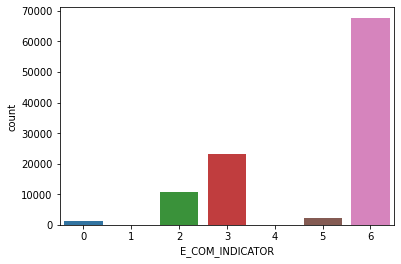

In [58]:
sns.countplot(data_dt_final['E_COM_INDICATOR'])

The values don't seem balanced so we will try to see if by oversampling and undersampling we can do that.

In [64]:
ros = RandomOverSampler(ratio='auto')
X_trainRos, y_trainRos = ros.fit_sample(X_train, y_train)
X_valRos, y_valRos = ros.fit_sample(X_val, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [66]:
xgb_clf2 = XGBClassifier(n_estimators=best_n_estimators, learning_rate=0.75, max_features=2, max_depth=2, random_state=0)
xgb_clf2.fit(X_trainRos, y_trainRos)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.75, max_delta_step=0, max_depth=2, max_features=2,
              min_child_weight=1, missing=None, n_estimators=18, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [67]:
score = xgb_clf2.score(X_valRos, y_valRos)
print(score)

0.9410562368799028


In [68]:
predictions = xgb_clf2.predict(X_valRos)
metrics.f1_score(y_valRos, predictions, average='weighted', labels=np.unique(predictions))

0.9396662301214798

##### The f1_score seems to reduce slightly but is still very good and the previous model seems to be overfitted a little, this is encountered somewhat here and makes a more robust classifier.

In [69]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

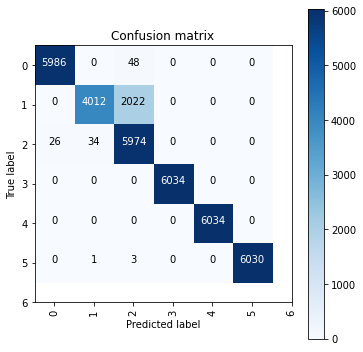

In [71]:
confusion_mtx = confusion_matrix(y_valRos, predictions) 
plot_confusion_matrix(confusion_mtx, classes = list(set(data_dt_final['E_COM_INDICATOR']))) 
plt.show()

##### We can plot similar confusion matrices for the other classifiers and compare, the aim is to get most values on the diagonal since that means that the true label and the predicted label matches

### **ROUGH WORK**

In [38]:
## To Do
